In [1]:
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_data = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=2048, shuffle=True, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=2048, shuffle=False, num_workers=2, pin_memory=True)

class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170M/170M [00:01<00:00, 104MB/s]


In [3]:
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64*5*5, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
net = NeuralNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.5)
scaler = torch.cuda.amp.GradScaler()

/tmp/ipython-input-2449427600.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/cuda/amp/grad_scaler.py:31: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  super().__init__(


In [ ]:
for epoch in range(50):
    net.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = net(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
    # scheduler.step()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

torch.save(net.state_dict(), 'trained_net.pth')

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-1573899403.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1, Loss: 2.2869, LR: 0.050000
Epoch 2, Loss: 2.0567, LR: 0.050000
Epoch 3, Loss: 1.8215, LR: 0.050000
Epoch 4, Loss: 1.6066, LR: 0.050000
Epoch 5, Loss: 1.6140, LR: 0.050000
Epoch 6, Loss: 1.5054, LR: 0.050000
Epoch 7, Loss: 1.3695, LR: 0.050000
Epoch 8, Loss: 1.2759, LR: 0.050000
Epoch 9, Loss: 1.1922, LR: 0.050000
Epoch 10, Loss: 1.1141, LR: 0.050000
Epoch 11, Loss: 1.0752, LR: 0.050000
Epoch 12, Loss: 1.0292, LR: 0.050000
Epoch 13, Loss: 0.9625, LR: 0.050000
Epoch 14, Loss: 0.9476, LR: 0.050000
Epoch 15, Loss: 0.8914, LR: 0.050000
Epoch 16, Loss: 0.8040, LR: 0.050000
Epoch 17, Loss: 0.7675, LR: 0.050000
Epoch 18, Loss: 0.7324, LR: 0.050000
Epoch 19, Loss: 0.6867, LR: 0.050000
Epoch 20, Loss: 0.6318, LR: 0.050000
Epoch 21, Loss: 0.6039, LR: 0.050000
Epoch 22, Loss: 0.5441, LR: 0.050000
Epoch 23, Loss: 0.5458, LR: 0.050000
Epoch 24, Loss: 0.5850, LR: 0.050000
Epoch 25, Loss: 0.4537, LR: 0.050000
Epoch 26, Loss: 0.3876, LR: 0.050000
Epoch 27, Loss: 0.3575, LR: 0.050000
Epoch 28, 

Accuracy: 72.50%


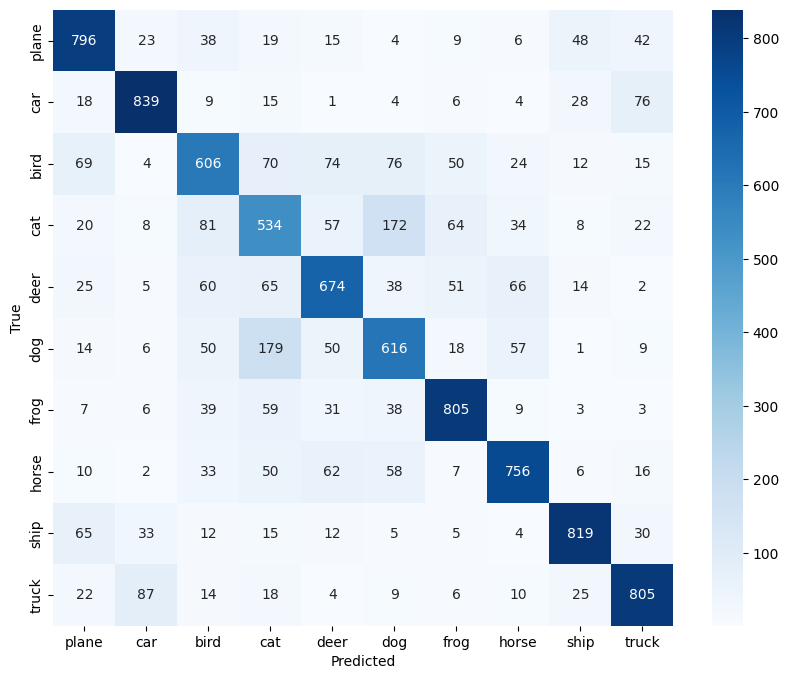

In [ ]:
net = NeuralNet()
net.load_state_dict(torch.load("trained_net.pth", map_location=torch.device('cpu')))
net.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
print(f"Accuracy: {acc:.2f}%")

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
new_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = new_transform(image)
    image = image.unsqueeze(0).to(device)
    return image

image_paths = ["/content/download.jpg"]
images = [load_image(img) for img in image_paths]
net.eval()
with torch.no_grad():
    for image in images:
        output = net(image)
        _, predicted = torch.max(output, 1)
        print(f'Prediction: {class_names[predicted.item()]}')

FileNotFoundError: [Errno 2] No such file or directory: '/content/download.jpg'